# Imports

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# Exploratory analysis

## Data description:

*   age. Age of primary beneficiary (numeric)
*   sex. Gender of the primary beneficiary (categorical)
*   bmi. Body mass index (numeric)
*   children. Number of children/dependents covered by health insurance (numeric)
*   smoker. smoker (categorical)
*   region. Beneficiary's residential area in the U.S.: northeast,southeast, southwest, northwest (categorical)
*   charges. Health insurance premium (numerical)

## Opening data

In [23]:
link='https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
health_raw=pd.read_csv(link)

In [24]:
health_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [25]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Checking for duplicates

In [26]:
print(health_raw.duplicated().sum())

1


### Checking categorical variables:

In [27]:
health_raw.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [28]:
cat=['sex', 'smoker','region']
for x in cat:
  print(health_raw[x].value_counts())
  print('\n')

sex
male      676
female    662
Name: count, dtype: int64


smoker
no     1064
yes     274
Name: count, dtype: int64


region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64




### Converting categorical variables into dummies/binary variables

In [29]:
health_raw=pd.get_dummies(health_raw, columns=cat, drop_first=True)


### Summary statistics:

*   The average age is 39
*   Observations in the sample are overweight and slightly obese given the average bmi of 30.6
*   The number of children covered on average is 1
*   The health insurance premium is on average 13.2K USD
*   Roughly 50% of the sample are female
*   About 20% of the sample are smokers
*   Roughly 24% of the sample lives in the northeast, northwest or southwest regions


In [30]:
health_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### Graphical analysis

Correlation map:
*   Smoker and charges are relatively highly correlated, as expected, smoking is associated with more health complications which is associated with a more expensive health premium

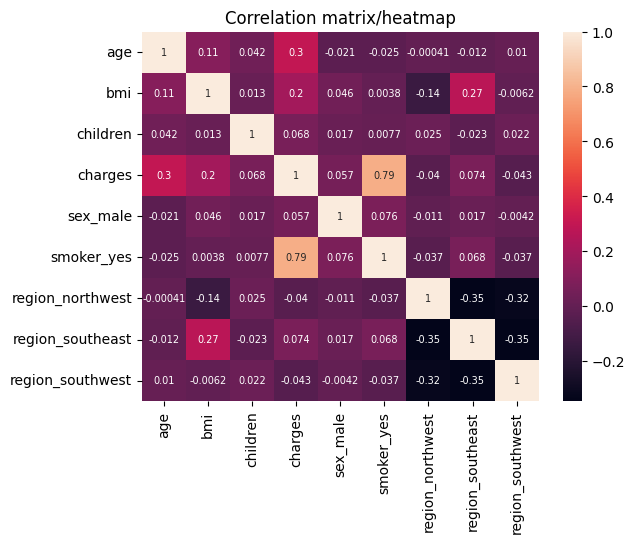

In [31]:
sns.heatmap(health_raw.corr(), annot=True, annot_kws={'size':7})
plt.title('Correlation matrix/heatmap')
plt.show()

Pairplot:
*   There seem to be 3 groups of charges when looking at charges vs age

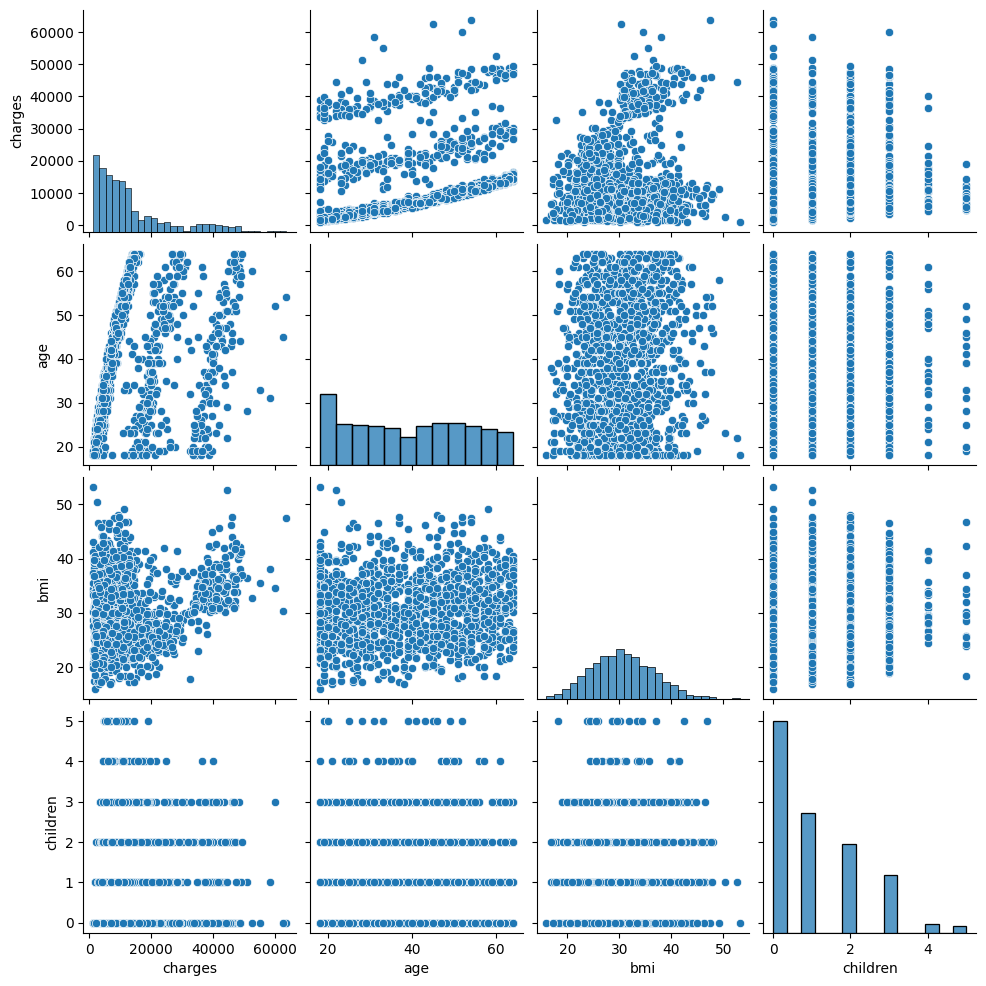

In [32]:
num_vars=['charges','age','bmi','children']
sns.pairplot(health_raw[num_vars], corner=False)
plt.show()

# Preparing data for linear regression

## Splitting data

Not using selection features this time as ther are few explanatory variables

In [33]:
# Dividing data intro train and test
X = health_raw.drop(['charges'], axis = 1) #y is the dependent variable
y = health_raw["charges"] #dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Normalising numerical variables:

In [34]:
to_scale=['age','bmi','children']
scaler=StandardScaler()
scaler.fit(X_train[to_scale])

train_norm = pd.DataFrame(scaler.transform(X_train[to_scale]), index=X_train.index, columns=to_scale)
test_norm = pd.DataFrame(scaler.transform(X_test[to_scale]), index=X_test.index, columns=to_scale)

X_train_n=X_train.copy()
X_train_n[to_scale]=train_norm[to_scale]

X_test_n=X_test.copy()
X_test_n[to_scale]=test_norm[to_scale]

######Storing scaled and unscaled data and scaler

X_train.to_csv('/workspaces/ML-OLS-HealthData/data/interim/X_train_sc.csv', index=False) #UNscaled
X_train_n.to_csv('/workspaces/ML-OLS-HealthData/data/interim/X_train_sc.csv', index=False) #Scaled
open("/workspaces/ML-OLS-HealthData/data/interim/y_train.txt", "w").write(y_train.to_string(index=False))

X_test.to_csv('/workspaces/ML-OLS-HealthData/data/interim/X_test.csv', index=False) #UNscaled
X_test_n.to_csv('/workspaces/ML-OLS-HealthData/data/interim/X_test_sc.csv', index=False) #Scaled
open("/workspaces/ML-OLS-HealthData/data/interim/y_test.txt", "w").write(y_test.to_string(index=False))

dump(scaler, open('/workspaces/ML-OLS-HealthData/data/interim/mm_scaler.pk', 'wb')) #storing scaler
